In [1]:
from lionagi.core.message import System, Instruction
from lionagi.core.execute.structure_executor import StructureExecutor
from lionagi.core.execute.instruction_map_executor import InstructionMapExecutor
from lionagi.core.agent.base_agent import BaseAgent

from lionagi.core.generic.edge_condition import EdgeCondition

In [2]:
# let us use a simple conditional calculator as an example
# in this example, we will have two steps in the instruction, first step would be choosing between sum or diff based on a case number
# and second step would be choosing between times or plus based on the sign of the first step

system = System(
    "You are asked to perform as a calculator. Return only a numeric value, i.e. int or float, no text."
)

# case 0
instruct1 = Instruction(
    instruction={
        "sum the absolute values": "provided with 2 numbers, return the sum of their absolute values. i.e. |x|+|y|",
    }
)

# case 1
instruct2 = Instruction(
    instruction={
        "diff the absolute values": "provided with 2 numbers, return the difference of absolute values. i.e. |x|-|y|",
    }
)

instruct3 = Instruction(
    instruction={
        "if previous response is positive": "times 2. i.e. *2",
        "else": "plus 2. i.e. +2",
    }
)

In [3]:
struct_calc = StructureExecutor()
struct_calc.add_node(system)
struct_calc.add_node(instruct1)
struct_calc.add_node(instruct2)
struct_calc.add_node(instruct3)

### Create Relationship Conditions

Conditions help filter the path to be executed.
It has to be an implemented subclass of Condition class.

There are two functions in Condition class:

```python
def __init__(self, source)
```

`source` can only be "structure" or "executable"

```python
@abstractmethod
def applies(self, source)
```

All information in the structure and executable object is available for checking. 
`applies` is expected to return a bool. If True, the path is selected.

If the `source` is "structure", the `source` is expected to be the structure object in the agent when checking the condition. 

If the `source` is "executable", the `source` is expected to be the executable object in the agent when checking the condition. If the executable object is `InstructionMapExecutor`, source would be the `BranchExecutor` object for the corresponding path.

In [4]:
class CaseCondition(EdgeCondition):
    def __init__(self, case):
        super().__init__(source="executable")
        self.case = case

    async def applies(self, executable):
        case = executable.context["case"]
        return case == self.case


cond0 = CaseCondition(case=0)
cond1 = CaseCondition(case=1)

### Build Relationships with Conditions

In this example, if `case` is 0, execute `instruct1`, or if `case` is 1, execute `instruct2`.

Then, execute `instruct3`.

In [5]:
struct_calc.add_edge(system, instruct1, condition=cond0)
struct_calc.add_edge(system, instruct2, condition=cond1)
struct_calc.add_edge(instruct1, instruct3)
struct_calc.add_edge(instruct2, instruct3)

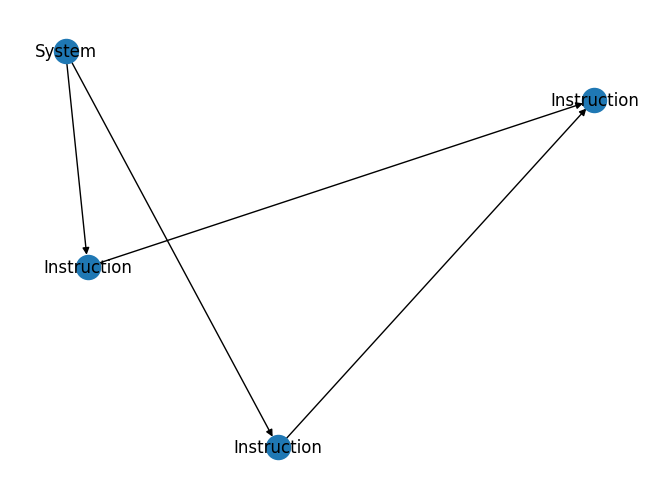

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

g = struct_calc.to_networkx()
labels = nx.get_node_attributes(g, "class_name")
nx.draw(g, labels=labels)

In [7]:
## output_parser parameter: agent self
## output_parser return: the expected result that should be returned after execution
def output_parser(agent):
    ## return all message dataframe in all branches
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.to_df())
    return output


executable = InstructionMapExecutor()

In [8]:
calculator = BaseAgent(
    structure=struct_calc, executable=executable, output_parser=output_parser
)

In [9]:
result = await calculator.execute(context={"x": -6, "y": 0, "case": 0})

------------------Welcome: system--------------------


system: You are asked to perform as a calculator. Return only a numeric value, i.e. int or float, no text.

user: {"sum the absolute values": "provided with 2 numbers, return the sum of their absolute values. i.e. |x|+|y|"}

assistant 72600e79ea985b2ef79314cc67285ac4: 6

-----------------------------------------------------


user: {"if previous response is positive": "times 2. i.e. *2", "else": "plus 2. i.e. +2"}

assistant 72600e79ea985b2ef79314cc67285ac4: 12

-----------------------------------------------------


In [10]:
result[0]

,ln_id,message_type,timestamp,role,content,metadata,sender,recipient
0,30ffb86ed1f5c3d462ebc4bf89574f9b,System,2024-05-21T19:25:14.303263,system,{'system_info': 'You are asked to perform as a...,{'last_updated': {'recipient': '2024-05-21T19:...,system,72600e79ea985b2ef79314cc67285ac4
1,08bc07e2dee2c96a9a4b0097cfc289ce,Instruction,2024-05-21T19:25:16.283602,user,{'instruction': {'sum the absolute values': 'p...,{'last_updated': {'sender': '2024-05-21T19:25:...,user,72600e79ea985b2ef79314cc67285ac4
2,72840f52fbbee5426ce6a59f09a0a79a,AssistantResponse,2024-05-21T19:25:16.881063,assistant,{'assistant_response': '6'},{'last_updated': {'sender': '2024-05-21T19:25:...,72600e79ea985b2ef79314cc67285ac4,user
3,3c75acc3d287b27d4f60161a5e8f78f3,Instruction,2024-05-21T19:25:17.295988,user,{'instruction': {'if previous response is posi...,{'last_updated': {'sender': '2024-05-21T19:25:...,user,72600e79ea985b2ef79314cc67285ac4
4,9b3f0b618665dcbc90b3452b48922216,AssistantResponse,2024-05-21T19:25:17.672223,assistant,{'assistant_response': '12'},{'last_updated': {'sender': '2024-05-21T19:25:...,72600e79ea985b2ef79314cc67285ac4,user


# Storing Structures

We currently support the storage of structures in Excel and Neo4j, enabling their reuse in future applications.

### Excel

In [11]:
struct_calc.to_excel("math")  # dir = "structure_storage" (default)

### Neo4j

In [12]:
# initiate Neo4j Driver
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
database = "neo4j"

from lionagi.integrations.storage.neo4j import Neo4j

neo4j = Neo4j(uri, user, password, database)

In [13]:
# structure_name is unique

await neo4j.store(struct_calc, structure_name="math")